# The North Face ecommerce project


Contents
--------
1. [Loading the dataset](#loading)
2. [Preliminary EDA](#eda)
2. [Conclusion and perspectives](#conclusion)



In [3]:
import csv
import re
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import spacy
import wordcloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

## <a id="loading"></a> Data loading and preprocessing

download with `python -m spacy download en_core_web_sm`

- remove stop words
- remove punctuation
- normalize to lowercase

In [4]:
## Load the file
with open('./sample-data.csv', 'rt', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_STRINGS)
    next(reader, None) # remove header
    data = [row for row in reader]

description_id = [row[0] for row in data]
descriptions = [row[1] for row in data]

In [5]:
## remove HTML tags
descriptions = [re.sub(r'<[a-z/]+>', ' ', d) for d in descriptions]

In [6]:
## normalize into lemmas
nlp = spacy.load('en_core_web_sm')
corpus = []
for desc in descriptions:
    doc = nlp(desc)
    doc = ' '.join(wd.lemma_.lower() for wd in doc
                   if not wd.is_stop and (wd.is_alpha))#  or wd.like_num))
    corpus.append(doc)
corpus = np.array(corpus, dtype=object)

### Construction of the TF-IDF matrix

In [7]:
vectorizer = CountVectorizer(token_pattern=r'[^\s]+')
word_counts = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names_out()

tfidf = TfidfTransformer(norm='l2').fit_transform(word_counts)

### A first wordcloud

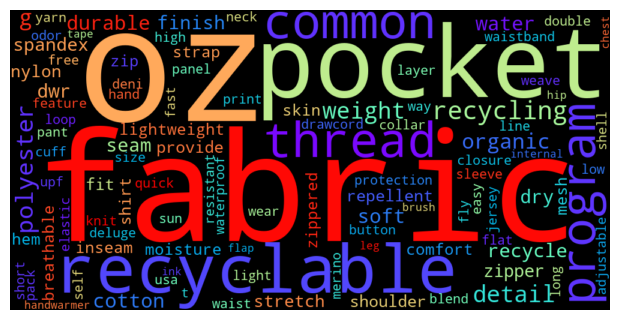

In [8]:
def create_wordcloud(text: str, **kwargs)-> np.ndarray:
    """
    !!! re-doc
    Return a numpy array representing a wordcloud of the array.
    """
    defaults = {'width': 1000, 'height': 500, 'min_font_size': 14,
                'colormap': 'rainbow', 'collocations': False,
                'random_state': 1234}    
    wc = wordcloud.WordCloud(**(defaults | kwargs))
    wc = wc.generate(text)
    return wc.to_array()


wc_arr = create_wordcloud(' '.join(corpus))
xy_ratio = wc_arr.shape[0] / wc_arr.shape[1]

wc_fig1 = plt.figure(figsize=(6, 6*xy_ratio), dpi=100)
wc_ax1 = wc_fig1.add_axes(rect=(0, 0, 1, 1))

wc_ax1.axis('off')
wc_ax1.imshow(wc_arr, interpolation='bilinear')

plt.show()

## <a id="clustering"></a> Descriptions clustering

Our data lies in high dimension (about 4000), with only 500 observations.

### Clustering with DBSCAN

In [ ]:
## Setup scanned parameters
eps_vals = np.linspace(0.5, 0.9, 21)
min_samples_vals = np.arange(1, 16, 1)
sh = (len(min_samples_vals), len(eps_vals))

## Grid search and record number of clusters and outliers
nb_clusters = np.zeros(sh, dtype=int)
nb_outliers = np.zeros(sh, dtype=int)
for i, j in np.ndindex(sh):
    dbc = DBSCAN(eps=eps_vals[j], min_samples=min_samples_vals[i],
                 metric='cosine', leaf_size=1)
    dbc = dbc.fit(tfidf)
    dbc_labels = dbc.labels_
    nb_clusters[i, j] = len(np.unique(dbc_labels)) - 1
    nb_outliers[i, j] = np.sum(dbc_labels==-1)

In [ ]:
##
fig1, axs1 = plt.subplots(
    nrows=2, ncols=2, sharex=False, sharey=False, figsize=(8.4, 4.2), dpi=200,
    gridspec_kw={'left': 0.07, 'right': 0.96, 'top': 0.81, 'bottom': 0.09,
                 'height_ratios': [0.07, 1], 'hspace': 0.04, 'wspace': 0.12})
fig1.suptitle("Figure 1: Maps of numbers of clusters and outliers for the grid search",
              x=0.02, ha='left', fontsize=12)


axs1[1, 0].set_aspect('equal')
cmap1 = plt.get_cmap('tab20b').copy()
cmap1.set_extremes(under='0.1', over='0.9')
heatmap1 = axs1[1, 0].pcolormesh(nb_clusters, cmap=cmap1, vmin=4.5, vmax=24.5,
                                 edgecolors='0.15', linewidth=0.05)

axs1[1, 0].set_xticks(np.linspace(0.5, 20.5, 5), eps_vals[::5])
axs1[1, 0].set_yticks(np.linspace(0.5, 14.5, 8), min_samples_vals[::2])
axs1[1, 0].set_ylabel('`min_samples`', fontsize=11)
fig1.text(0.5, 0.022, 'max sample distance (`eps`)', fontsize=11, ha='center')

fig1.colorbar(heatmap1, cax=axs1[0, 0], orientation='horizontal', ticklocation='top')
axs1[0, 0].tick_params(pad=1)
axs1[0, 0].set_xticks(np.linspace(5, 23, 10), np.arange(5, 24, 2))
axs1[0, 0].set_title('Number of clusters')


axs1[1, 1].set_aspect('equal')
cmap2 = plt.get_cmap('plasma').copy()
cmap2.set_extremes(under='0.1', over='0.9')
heatmap2 = axs1[1, 1].pcolormesh(nb_outliers, cmap=cmap2, vmin=0, vmax=100,
                                 edgecolors='0.15', linewidth=0.1)

axs1[1, 1].set_xticks(np.linspace(0.5, 20.5, 5), eps_vals[::5])
axs1[1, 1].set_yticks(np.linspace(0.5, 14.5, 8), min_samples_vals[::2])

fig1.colorbar(heatmap2, cax=axs1[0, 1], orientation='horizontal', ticklocation='top')
axs1[0, 1].set_title('Number of outliers')


plt.show()

Figure 1

In [ ]:

valid_params_idx = (nb_outliers <= 60) * (nb_clusters >= 8) * (nb_clusters <= 24)
valid_min_samples_idx, valid_eps_idx = np.nonzero(valid_params_idx)

for i, j in zip(valid_min_samples_idx, valid_eps_idx):
    print(f'min_samples = {min_samples_vals[i]} ; eps = {eps_vals[j]:<5.2f}',
          f'==>  {nb_clusters[i, j]:>2} clusters, {nb_outliers[i, j]:>2} outliers')

We retrain the configuration with 9 clusters and 7 outliers.

In [ ]:
dbc = DBSCAN(eps=0.7, min_samples=4, metric='cosine', leaf_size=1).fit(tfidf)
dbc_labels = dbc.labels_
nb_dbc = len(np.unique(dbc_labels)) - 1

print('======== DBSCAN ========',
      f'\nNumber of clusters: {nb_dbc}',
      f'\nNumber of outliers: {np.sum(dbc_labels==-1)}')
print(np.unique(dbc_labels, return_counts=True)[0])
print(np.unique(dbc_labels, return_counts=True)[1])